# XGBOOST - TEST

In [1]:
import numpy as np
from sklearn import datasets
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import pandas as pd
from datetime import datetime
from time import time
from sklearn.metrics import balanced_accuracy_score
%matplotlib inline
import matplotlib.pyplot as plt

### GLOBAL VARIABLES

In [2]:
DATAPATH = 'data/train_test/'
SEED = 47
NITER = 100
CV = 3
SCORE = 'balanced_accuracy'
handlingnull = False
NJOBS = 7
USEGPU = False
NCLASS = 3 # number class to predict (if bivar set 0)

### FUNCTIONS

In [3]:
def plot_roc_curve(y_true, y_score):
    logit_roc_auc = roc_auc_score(y_true, y_score)
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    plt.figure()
    plt.plot(fpr, tpr, label='Xgboost (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    pass

In [4]:
def plot_importance(booster, figsize=(10,5), feature_names=None, **kwargs): 
    
    fig, ax = plt.subplots(1,1,figsize=figsize) 
    
    if feature_names:
        mapper = {'f{0}'.format(i): v for i, v in enumerate(feature_names)}
        mapped = {mapper[k]: v for k, v in booster.get_fscore().items()}
        return xgb.plot_importance(mapped, ax=ax, **kwargs)
    else:
        return xgb.plot_importance(booster=booster, ax=ax, **kwargs)
    pass

In [5]:
def plot_score_dist(y_true, y_score):
    
    df = pd.DataFrame(data=np.column_stack((y_true, y_score)), columns=['target','score'])
    
    plt.figure(figsize=(7, 4))
    ax = sns.boxplot(x="target", y="score", data=df)
    ax.set_title("Score distribution")

    pass

### LOAD DATASET

In [6]:
train_features = np.load(DATAPATH+'X_wavelet_discrete_train.npy')

In [7]:
train_labels = np.load(DATAPATH+'y_wavelet_discrete_train.npy')

In [8]:
test_features = np.load(DATAPATH+'X_wavelet_discrete_test.npy')

In [9]:
test_labels = np.load(DATAPATH+'y_wavelet_discrete_test.npy')

In [10]:
feature_names = np.load('data/features/X_wavelet_discrete_names.npy').tolist()

### TRAIN MODEL

#### Set hyperparameters

In [11]:
# ======== General Parameters ======= #

# Select the type of model to run at each iteration. gbtree or gblinear.
booster = 'gbtree'


# ======== Booster Parameters ======== # 

# Analogous to learning rate in GBM. 
# Typical final values to be used: 0.01-0.2
eta = [0.01] 


# Control the balance of positive and negative weights, useful for unbalanced classes. 
# A typical value to consider: sum(negative instances) / sum(positive instances)scale_pos_weight = 1
scale_pos_weight = [5,1,2]


# Learning Task Parameters

# This defines the loss function to be minimized. 
# - binary:logistic –logistic regression for binary classification, returns predicted probability (not class)
# - multi:softmax –multiclass classification using the softmax objective, returns predicted class (not probabilities)
#   you also need to set an additional num_class (number of classes) parameter defining the number of unique classes
# - multi:softprob –same as softmax, but returns predicted probability of each data point belonging to each class.
objective  = 'multi:softprob'


# The metric to be used for validation data.
# - rmse – root mean square error
# - mae – mean absolute error
# - logloss – negative log-likelihood
# - error – Binary classification error rate (0.5 threshold)
# - merror – Multiclass classification error rate
# - mlogloss – Multiclass logloss
# - auc: Area under the curve
eval_metric = 'mlogloss'

In [12]:
xgb_params = np.load('output/hyperparameters/rseach_xgboost_classifier_bestparams_d2019-11-09.npy', allow_pickle=True).tolist()

In [13]:
xgb_params

{'subsample': 0.7,
 'reg_lambda': 0.5,
 'reg_alpha': 0.05,
 'min_child_weight': 1,
 'max_depth': 9,
 'learning_rate': 0.01,
 'gamma': 0.4,
 'colsample_bytree': 0.8}

In [14]:
xgb_params['n_estimators'] = 54

In [15]:
xgb_params['seed'] = SEED
xgb_params['booster'] = booster
xgb_params['objective'] = objective
xgb_params['eval_metric'] = eval_metric
xgb_params['num_threads'] = NJOBS
xgb_params['num_class'] = NCLASS
xgb_params['verbose'] = 0
xgb_params['scale_pos_weight'] = scale_pos_weight

In [16]:
if USEGPU:
    xgb_params['tree_method'] = 'gpu_hist'
    xgb_params['gpu_id'] = 0

In [17]:
### create a DMatrix and handling Null values
if handlingnull:
    #train_features[np.isnan(train_features)] = -9999
    xgtrain = xgb.DMatrix(train_features, train_labels, missing=-9999)
    xgtest = xgb.DMatrix(test_features, missing=-9999)
else:
    xgtrain = xgb.DMatrix(train_features, train_labels)
    xgtest = xgb.DMatrix(test_features, missing=-9999)

In [18]:
model = xgb.train(xgb_params, xgtrain, verbose_eval=False)

[02:42:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[02:42:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 4 pruned nodes, max_depth=9
[02:42:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 4 pruned nodes, max_depth=9
[02:42:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 2 pruned nodes, max_depth=9
[02:42:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[02:42:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 6 pruned nodes, max_depth=9
[02:42:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 6 pruned nodes, max_depth=9
[02:42:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[02:42:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 6 pruned nodes, max_

In [19]:
y_pred = model.predict(xgtest)

In [21]:
print(SCORE,' : ', balanced_accuracy_score(test_labels, np.argmax(y_pred,axis=1)))

balanced_accuracy  :  0.7492768459458751


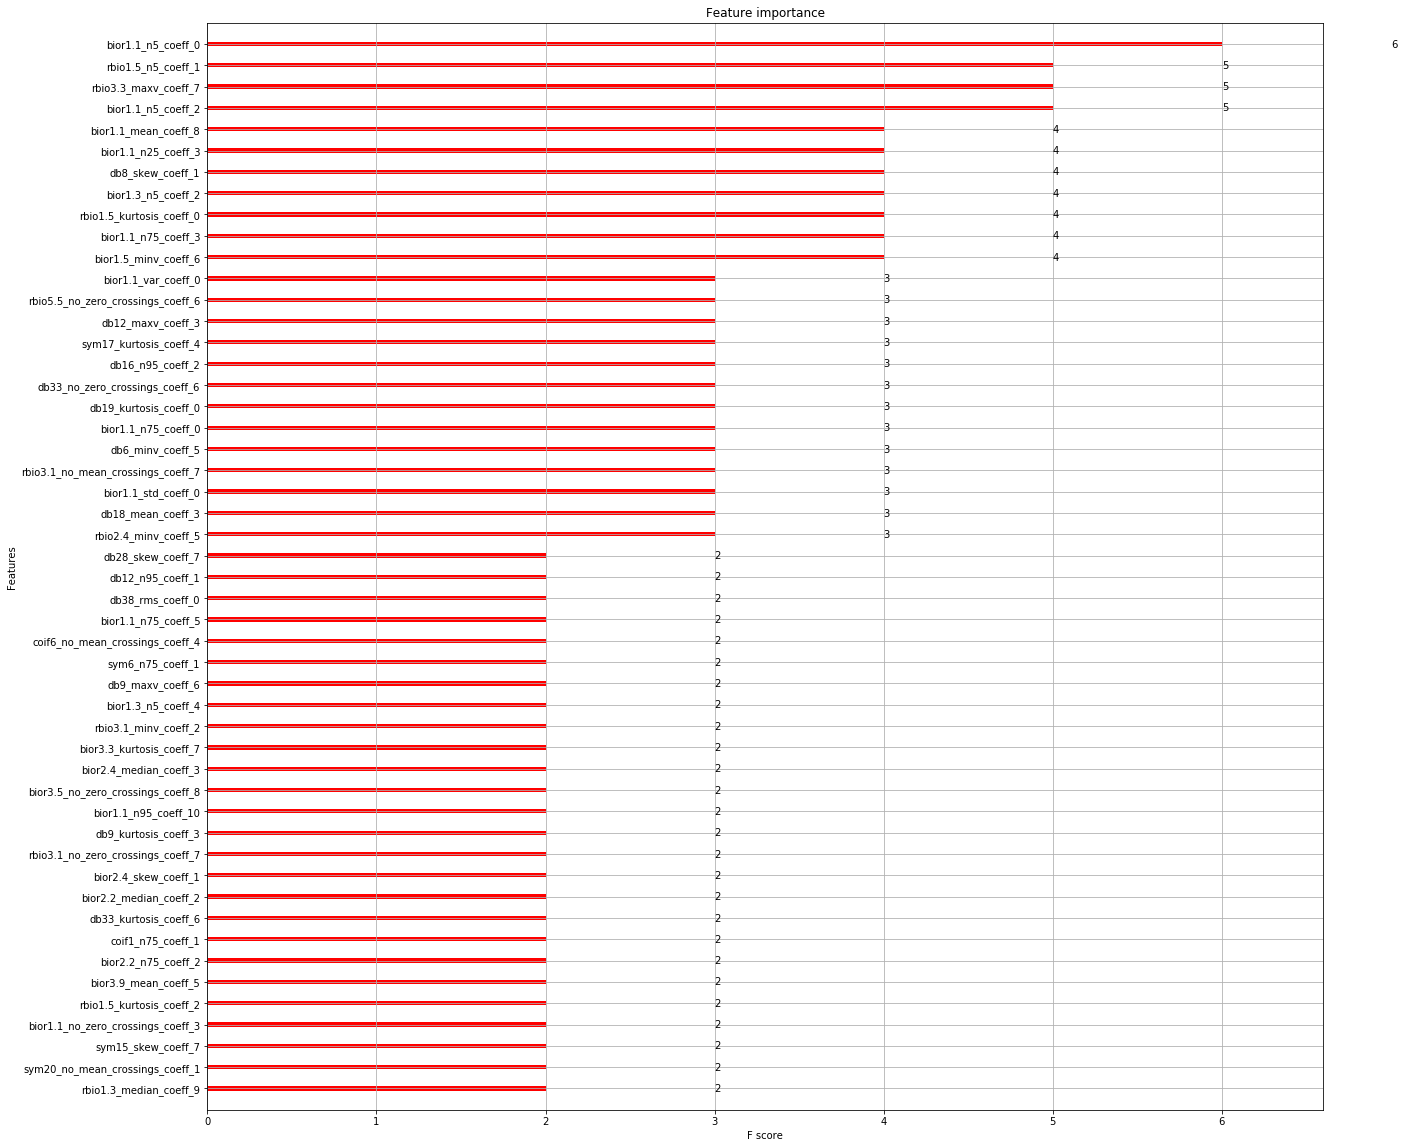

In [22]:
plot_importance(model, figsize=(20,20), feature_names=feature_names, max_num_features=50, color='red')
pass

In [23]:
df = pd.DataFrame(data=np.column_stack((test_labels,np.argmax(y_pred,axis=1))), columns=['target','score'])

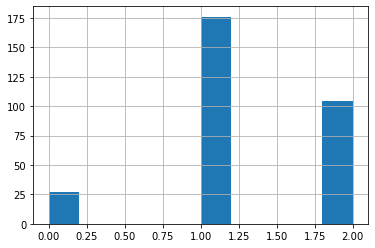

In [24]:
df['score'].hist()
pass